In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import datetime
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from skimage.util import pad
import skimage
import time
import math

from tqdm import tqdm_notebook as tqdm 

from Dataset import DataSet,Scale,ToTensor,RandomGaussionBlur,RandomMedianBlur\
,RandomHorizontalFlip,RandomRotation,visualize_loader

import warnings
warnings.filterwarnings('ignore')

from Models import DualEncoding_U_Net, save_model,load_model,init_weights,DualEncodingDecoding_U_Net
from Metrics import SoftDiceLoss,dice_metric,MultiClassBCE,SoftDiceLoss,DE_loss
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
    
import pickle



In [2]:

h_e_train_patch_dir='other_data/CPM_17/{}/H_E_patches'.format('Train')
h_train_patch_dir='other_data/CPM_17/{}/H_patches'.format('Train')

nuclei_mask_train_patch_dir='other_data/CPM_17/{}/nuclei_patches'.format('Train')
boundary_mask_train_patch_dir='other_data/CPM_17/{}/boundary_patches'.format('Train')

h_e_test_patch_dir='other_data/CPM_17/{}/H_E_patches'.format('Test')
h_test_patch_dir='other_data/CPM_17/{}/H_patches'.format('Test')

nuclei_mask_test_patch_dir='other_data/CPM_17/{}/nuclei_patches'.format('Test')
boundary_mask_test_patch_dir='other_data/CPM_17/{}/boundary_patches'.format('Test')

95
85
MAX VALUE :  
H&E 1.0 
H 1.0 
nuclei_mask 1.0 
boundary_mask 1.0


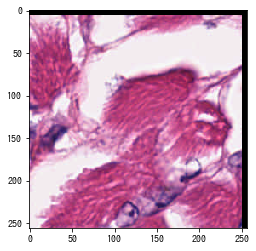

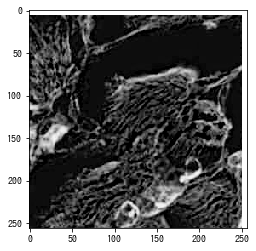

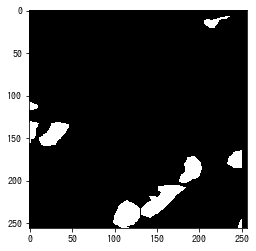

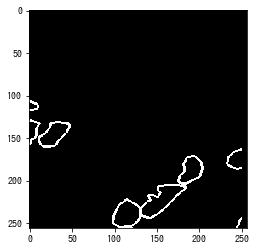

In [3]:
batch_size_train=4
batch_size_test=4
                                                
train_transform=torchvision.transforms.Compose([RandomGaussionBlur(p=0.4,sigma=0.5,truncate=4,apply_dual=False),\
                                                RandomMedianBlur(p=0.4,disk_rad=1),\
                                                RandomHorizontalFlip(p=0.4),\
                                                RandomRotation( degrees=[60,120],p=0.38),\
                                                Scale(),\
                                                ToTensor()])
test_transform=torchvision.transforms.Compose([Scale(),ToTensor()])
train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                      ,nuclei_mask_train_patch_dir, boundary_mask_train_patch_dir\
                      ,transform=train_transform,attn_gray=True)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                      ,nuclei_mask_test_patch_dir, boundary_mask_test_patch_dir\
                      ,transform=test_transform,attn_gray=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=False)

print(train_loader.__len__())
print(test_loader.__len__())
visualize_loader(test_loader,0)

In [4]:
# model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.4,include_ffm=False)
model=DualEncodingDecoding_U_Net(img_ch1=3,img_ch2=1,output_ch=1,dropout=0.45)
# model=AttnUNet(img_ch=2,output_ch=1,dropout=0.5)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_CPM_17_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('{} dir has been made'.format(BEST_MODEL_PATH))
print("Model's state_dict:")
writer = SummaryWriter('{}/experiment_{}'.format(BEST_MODEL_PATH,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/datalab/training-assets/R_medical/atheeth/nuclei_seg/model_CPM_17_2020_02_12 dir has been made
Model's state_dict:
Conv1_encoding_1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1_encoding_1.conv.0.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.weight 	 torch.Size([64])
Conv1_encoding_1.conv.1.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1_encoding_1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1_encoding_1.conv.3.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.weight 	 torch.Size([64])
Conv1_encoding_1.conv.4.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2_encoding_1.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2_encoding_1.conv.0.bias 	 torch.Size([128])
Conv2_encoding_1.co

Up_sample4_decod_1.up.2.num_batches_tracked 	 torch.Size([])
Up_conv4_decod_1.0.weight 	 torch.Size([256, 512, 1, 1])
Up_conv4_decod_1.0.bias 	 torch.Size([256])
Up_conv4_decod_1.1.weight 	 torch.Size([256])
Up_conv4_decod_1.1.bias 	 torch.Size([256])
Up_conv4_decod_1.1.running_mean 	 torch.Size([256])
Up_conv4_decod_1.1.running_var 	 torch.Size([256])
Up_conv4_decod_1.1.num_batches_tracked 	 torch.Size([])
Up_sample3_decod_1.up.1.weight 	 torch.Size([128, 256, 3, 3])
Up_sample3_decod_1.up.1.bias 	 torch.Size([128])
Up_sample3_decod_1.up.2.weight 	 torch.Size([128])
Up_sample3_decod_1.up.2.bias 	 torch.Size([128])
Up_sample3_decod_1.up.2.running_mean 	 torch.Size([128])
Up_sample3_decod_1.up.2.running_var 	 torch.Size([128])
Up_sample3_decod_1.up.2.num_batches_tracked 	 torch.Size([])
Up_conv3_decod_1.0.weight 	 torch.Size([128, 256, 1, 1])
Up_conv3_decod_1.0.bias 	 torch.Size([128])
Up_conv3_decod_1.1.weight 	 torch.Size([128])
Up_conv3_decod_1.1.bias 	 torch.Size([128])
Up_conv3_deco

In [5]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
pretrained=False
optimizer_selected='adam'
scheduler_type='reduce_on_plateau'
batchsize=batch_size_train
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=100
predict_boundary=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#criterion = SoftDiceLoss()#
criterion=nn.BCELoss()
# criterion=MultiClassBCE(weights=[0.65,0.35])
# criterion=DE_loss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)

if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-03, betas=(0.9, 0.98))#,weight_decay=0.02)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


if scheduler_type=='reduce_on_plateau':
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6,\
                                               verbose=True, threshold=0.0001, threshold_mode='rel',\
                                               cooldown=2, min_lr=10e-06, eps=1e-08)
    
else:
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)

if pretrained:
    filename='model_CPM_17_v2_2020_02_07/model_optim.pth'
    load_model(filename,model,optimizer=None,scheduler=None)
else:
    init_weights(model)

best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
                if predict_boundary:
                    h_e_train, h_train,nuclei_mask_train,boundary_mask_train = sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\
                    ,sample_batched['boundary_mask']
                    
                    h_e_train, h_train,nuclei_mask_train,boundary_mask_train = \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)\
                    ,boundary_mask_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=torch.cat((nuclei_mask_train,boundary_mask_train),dim=1)
                
                else:
                    h_e_train, h_train,nuclei_mask_train= sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\

                    h_e_train, h_train,nuclei_mask_train= \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=nuclei_mask_train

                # forward + backward + optimize
#                 img_batch_comb=torch.cat((img_batch,dapi_batch),dim=1)
                outputs,attn_maps_train= model(h_e_train,h_train)
                outputs=torch.sigmoid(outputs)
    
                if predict_boundary:
                    pred_nuclei_train,pred_boundary_train=torch.chunk(outputs,2,dim=1)
                else:
                    pred_nuclei_train=outputs
                

                
                loss = criterion(outputs, gt_mask_train)
                dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if (i+1)%50==0:
                    
                    if predict_boundary:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
                                             pred_boundary_train.detach().cpu(),boundary_mask_train.detach().cpu()),dim=0)
                    else:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu()),dim=0)
                        
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
                    torchvision.utils.save_image\
                    (img_grid2,os.path.join(BEST_MODEL_PATH,\
                                            'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                        
                    attn_index=np.random.randint(0,4)
                    torchvision.utils.save_image\
                    (attn_maps_train[attn_index][0][0],os.path.join(BEST_MODEL_PATH,\
                                            'attnMap{}_train_iter_{}.png'.format(attn_index,epoch*len(train_loader)+i+1)))
                    
                    
                    
#                     writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                if scheduler_type!='reduce_on_plateau':
                    scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
            
            writer.add_scalar('Train dice { epoch }',
                            run_avg_train_dice,
                            epoch+1)
                
            writer.add_scalar('Train loss { epoch }',
                    run_avg_train_loss,
                    epoch * len(train_loader) + i+1)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):
                
                
                if predict_boundary:
                    h_e_test, h_test,nuclei_mask_test,boundary_mask_test = test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']\
                    ,test_sample['boundary_mask']
                    
                    h_e_test, h_test,nuclei_mask_test,boundary_mask_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)\
                    ,boundary_mask_test.to(device, dtype = torch.float)
                    
                    gt_mask_test=torch.cat((nuclei_mask_test,boundary_mask_test),dim=1)
                    
                else:
                
                    h_e_test, h_test,nuclei_mask_test= test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']

                    h_e_test, h_test,nuclei_mask_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)

                    gt_mask_test=nuclei_mask_test
    
                test_outputs,attn_maps_test = model(h_e_test,h_test)
                test_outputs=torch.sigmoid(test_outputs)
        
        
                if predict_boundary:
                    pred_nuclei_test,pred_boundary_test=torch.chunk(test_outputs,2,dim=1)
                else:
                    pred_nuclei_test=test_outputs
    
                test_loss = criterion(test_outputs, gt_mask_test)
                test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
                if (j+1)%50==0:
                    if predict_boundary:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
                                                  pred_boundary_test.detach().cpu(),boundary_mask_test.detach().cpu()),dim=0)
                    else:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu()),dim=0)
                    
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid,os.path.join(BEST_MODEL_PATH,\
                                            'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
                    attn_index=np.random.randint(0,4)
                   
                    torchvision.utils.save_image\
                    (attn_maps_test[attn_index][0][0],os.path.join(BEST_MODEL_PATH,\
                                            'attnMap{}_test_iter_{}.png'.format(attn_index,epoch*len(test_loader)+j+1)))
                    
#                     writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            
            writer.add_scalar('Test dice { epoch }',
                            run_avg_test_dice,
                            epoch+1)
                
            writer.add_scalar('Test loss { epoch }',
                    run_avg_test_loss,
                    epoch * len(train_loader) + i+1)
            
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+\
                           '/model_optim.pth',scheduler=scheduler)
                print("saved model with test dice score: {}".format(best_val))
            if scheduler_type=='reduce_on_plateau':
                scheduler.step(run_avg_test_loss)
    
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

with open("{}/history.txt".format(BEST_MODEL_PATH), "wb") as fp:   #Pickling
    pickle.dump(history, fp)
    
    
    

Tesla V100-SXM2-32GB
initialized network with normal initialization
Learning Rate : 0.001



test_loss: 0.27588590480740205
test_dice :0.5887647129415422
saved model with test dice score: 0.5887647129415422
Learning Rate : 0.001



test_loss: 0.20869192300186168
test_dice :0.6080150631049781
saved model with test dice score: 0.6080150631049781
Learning Rate : 0.001



test_loss: 0.17215062894786612
test_dice :0.7242788399694189
saved model with test dice score: 0.7242788399694189
Learning Rate : 0.001



test_loss: 0.16062101468714682
test_dice :0.7293921851291796
saved model with test dice score: 0.7293921851291796
Learning Rate : 0.001



test_loss: 0.15835787827249115
test_dice :0.7527723028234377
saved model with test dice score: 0.7527723028234377
Learning Rate : 0.001



test_loss: 0.15315556991133397
test_dice :0.7581635498609013
saved model with test dice score: 0.7581635498609013
Learning Rate : 0.001



test_loss: 0.18267547329971343
test_dice :0.7256326617201366
Learning Rate : 0.001



test_loss: 0.14755031552011236
test_dice :0.784142207102112
saved model with test dice score: 0.784142207102112
Learning Rate : 0.001



test_loss: 0.15939101819262494
test_dice :0.7607675322158886
Learning Rate : 0.001




test_loss: 0.16943007999609896
test_dice :0.7580186206535218
Learning Rate : 0.001



test_loss: 0.14753551347392468
test_dice :0.7876301022610092
saved model with test dice score: 0.7876301022610092
Learning Rate : 0.001



test_loss: 0.1462297945932372
test_dice :0.7889027023627717
saved model with test dice score: 0.7889027023627717
Learning Rate : 0.001



test_loss: 0.14996128167477762
test_dice :0.7938949727491909
saved model with test dice score: 0.7938949727491909
Learning Rate : 0.001



test_loss: 0.15755198665147382
test_dice :0.7772461740522907
Learning Rate : 0.001



test_loss: 0.15258240167100434
test_dice :0.7772208250678235
Learning Rate : 0.001



test_loss: 0.14067915572836584
test_dice :0.823828263640906
saved model with test dice score: 0.823828263640906
Learning Rate : 0.001



test_loss: 0.1543287387341581
test_dice :0.8001559915795332
Learning Rate : 0.001



test_loss: 0.14691956768133943
test_dice :0.8014431667768906
Learning Rate : 0.001



test_loss: 0.14365277448024585
test_dice :0.8057042230070106
Learning Rate : 0.001



test_loss: 0.14811350735806098
test_dice :0.8026878028970703
Learning Rate : 0.001



test_loss: 0.15230769459147495
test_dice :0.795649073198957
Learning Rate : 0.001



test_loss: 0.15891265119863351
test_dice :0.7701900884161834
Learning Rate : 0.001



test_loss: 0.14093558848101292
test_dice :0.793311151171002
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Learning Rate : 0.0001



test_loss: 0.1392194449779359
test_dice :0.8111848416047913
Learning Rate : 0.0001



test_loss: 0.14080215452855496
test_dice :0.8133016658140275
Learning Rate : 0.0001



test_loss: 0.15200676553628045
test_dice :0.7977964316745664
Learning Rate : 0.0001



test_loss: 0.142289709068252
test_dice :0.8126995738837693
Learning Rate : 0.0001



test_loss: 0.14011836753927126
test_dice :0.8165929786692214
Learning Rate : 0.0001



test_loss: 0.13560022850197678
test_dice :0.8195425562180493
Learning Rate : 0.0001



test_loss: 0.14180808292848898
test_dice :0.8158177317123001
Learning Rate : 0.0001



test_loss: 0.14245561519752595
test_dice :0.816125450439027
Learning Rate : 0.0001



test_loss: 0.13786583362013285
test_dice :0.8179099846831865
Learning Rate : 0.0001



test_loss: 0.14745212533844906
test_dice :0.8091581688029037
Learning Rate : 0.0001



test_loss: 0.14285518064969333
test_dice :0.8143215086076878
Learning Rate : 0.0001



test_loss: 0.1469788089527925
test_dice :0.8125701425210622
Learning Rate : 0.0001



test_loss: 0.14018091957420742
test_dice :0.8217497221223311
Epoch    36: reducing learning rate of group 0 to 1.0000e-05.
Learning Rate : 1e-05



test_loss: 0.1412125906946115
test_dice :0.8197598116927886
Learning Rate : 1e-05



test_loss: 0.14439287195743244
test_dice :0.8171516123758481
Learning Rate : 1e-05



test_loss: 0.14044020830274062
test_dice :0.8221762524553162
Learning Rate : 1e-05



test_loss: 0.14219687165460093
test_dice :0.8181339506618787
Learning Rate : 1e-05



test_loss: 0.14292071540516163
test_dice :0.818921128154721
Learning Rate : 1e-05



test_loss: 0.14366904047768853
test_dice :0.816365680859655
Learning Rate : 1e-05



test_loss: 0.14162130402293485
test_dice :0.8205059094808855
Learning Rate : 1e-05



test_loss: 0.14117664238187763
test_dice :0.820846082056901
Learning Rate : 1e-05



test_loss: 0.14145956875838042
test_dice :0.8191687569719711
Learning Rate : 1e-05



test_loss: 0.14293098608984603
test_dice :0.8180587472653964
Learning Rate : 1e-05



test_loss: 0.1421230213591025
test_dice :0.8182840960236507
Learning Rate : 1e-05



test_loss: 0.14214738142846375
test_dice :0.8202162243171219
Learning Rate : 1e-05



test_loss: 0.14263645341507325
test_dice :0.8185966289563075
Learning Rate : 1e-05



test_loss: 0.1415023489846594
test_dice :0.8209955362938154
Learning Rate : 1e-05



test_loss: 0.14267313407590543
test_dice :0.8187682074596017
Learning Rate : 1e-05



test_loss: 0.14249399715026287
test_dice :0.8170280544819303
Learning Rate : 1e-05



test_loss: 0.14423056194331976
test_dice :0.8176679154779809
Learning Rate : 1e-05



test_loss: 0.1432605905628146
test_dice :0.8176413959045857
Learning Rate : 1e-05



test_loss: 0.14447019100488803
test_dice :0.8155525272195032
Learning Rate : 1e-05



test_loss: 0.14174844603717832
test_dice :0.8197920124202263
Learning Rate : 1e-05



test_loss: 0.14332387034049232
test_dice :0.8180129300555353
Learning Rate : 1e-05



test_loss: 0.14903926188682728
test_dice :0.8130471876988653
Learning Rate : 1e-05



test_loss: 0.14104490080848198
test_dice :0.8208285907114345
Learning Rate : 1e-05



test_loss: 0.14119104340287927
test_dice :0.8202315081870367
Learning Rate : 1e-05



test_loss: 0.14357426496602907
test_dice :0.8172726497962701
Learning Rate : 1e-05



test_loss: 0.14619318464545142
test_dice :0.8158622698195124
Learning Rate : 1e-05



test_loss: 0.14267502372633706
test_dice :0.820461760482245
Learning Rate : 1e-05



test_loss: 0.14318252496393163
test_dice :0.8192982316782532
Learning Rate : 1e-05



test_loss: 0.14223419325877038
test_dice :0.8200799272476136
Learning Rate : 1e-05



test_loss: 0.14316646416503206
test_dice :0.8194108562987944
Learning Rate : 1e-05



test_loss: 0.14321616547742003
test_dice :0.8192248065444558
Learning Rate : 1e-05



test_loss: 0.14295251319661414
test_dice :0.8190704679266417
Learning Rate : 1e-05



test_loss: 0.14638003269944413
test_dice :0.8143888344585271
Learning Rate : 1e-05



test_loss: 0.14182104536685328
test_dice :0.8197125116992277
Learning Rate : 1e-05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
# save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler) 

In [7]:
# os.system("rm -rf {}".format(BEST_MODEL_PATH))